# Checking every step of preprocessing

In [2]:
import os
import numpy as np
import tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as ss
from scipy.stats import kurtosis, zscore
from sklearn import preprocessing
import keras
import PyQt5
from sklearn.model_selection import train_test_split
import pandas as pd
# %matplotlib notebook
mne.set_log_level(verbose='CRITICAL')

Using TensorFlow backend.


# Functions for preprocessing

In [3]:
def get_bad_channels(signal, ch_names, percentiles = [25,75]): #shape = (channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    Q1,Q3 = np.percentile(Qstd,percentiles)
    IQR = (Q3-Q1)*1.5
    range_std = (Q1-IQR,Q3+IQR)
    Q1,Q3 = np.percentile(Qkurt,percentiles)
    IQR = (Q3-Q1)*1.5
    range_kurt = (Q1-IQR,Q3+IQR)
    right_std = np.where(Qstd > range_std[1])[0]
    left_std = np.where(Qstd < range_std[0])[0]
    right_kurt = np.where(Qkurt > range_kurt[1])[0]
    left_kurt = np.where(Qkurt < range_kurt[0])[0]
    bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads.astype(int), np.array(ch_names)[bads.astype(int)]

def get_bad_epochs(signal,percentiles = [25,75]): #shape = ( epochs, channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    for i in range(channels):
        Q1,Q3 = np.percentile(Qstd[:,i],percentiles)
        IQR = (Q3-Q1)*1.5
        range_std = (Q1-IQR,Q3+IQR)
        Q1,Q3 = np.percentile(Qkurt[:,i],percentiles)
        IQR = (Q3-Q1)*1.5
        range_kurt = (Q1-IQR,Q3+IQR)
        right_std = np.where(Qstd[:,i] > range_std[1])[0]
        left_std = np.where(Qstd[:,i] < range_std[0])[0]
        right_kurt = np.where(Qkurt[:,i] > range_kurt[1])[0]
        left_kurt = np.where(Qkurt[:,i] < range_kurt[0])[0]
        bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads

def RMS(signal, window_size):
    signal2 = signal**2
    window = np.ones(window_size)/window_size
    return np.sqrt(np.convolve(signal2, window, 'same'))

def RMS_epochs(epochs,window_length=32): #(epochs, channels, samples)
    return np.apply_along_axis(RMS,-1,epochs,window_length)

### First step: reading data (using mne)

In [4]:
participant = 'k1'
file = mne.io.read_raw_eeglab('./data2/'+participant+'.set',preload=True)
before_ref = file.get_data() #extracting data before setting refrence channels to see any changes

'''Setting refrence channels (ears)'''
file.set_eeg_reference(ref_channels=['A1','A2']) 
after_ref = file.get_data() #extracting data after setting refrence (checking changes)

'''Dropping (removing) redundant channels'''
file.drop_channels(['EOG','dioda','TSS','A1','A2'])

<RawEEGLAB | k1.fdt, 19 x 4466688 (4362.0 s), ~647.5 MB, data loaded>

Plotting changes for refrence channels

https://mne.tools/dev/generated/mne.set_eeg_reference.html

It uses average in default

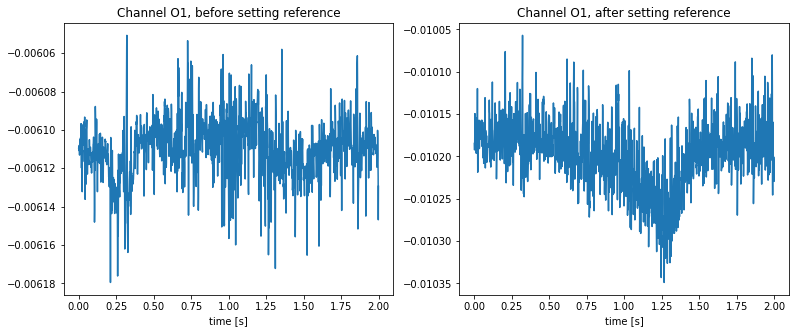

In [5]:
Fs = int(file.info['sfreq'])
channels = file.info['ch_names']

ch = 0
time = np.arange(0,2,1/Fs)

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(time,before_ref[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, before setting reference')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(time,after_ref[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, after setting reference')
plt.xlabel('time [s]')
plt.show()

### Second step: Filtering

#### Checking impulse response

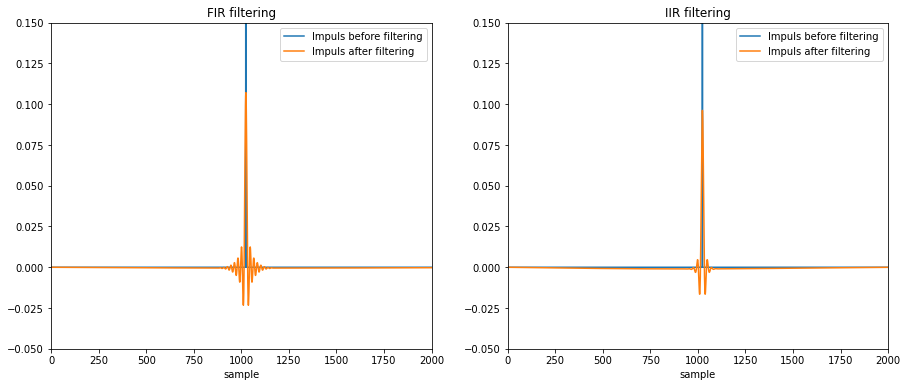

In [6]:
mne.set_log_level(verbose='CRITICAL')
'''FIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49) #default is fir method

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.xlabel('sample')
plt.title('FIR filtering')
plt.legend(loc = 'upper right')

'''IIR method'''
impulse = np.zeros(10*Fs)
impulse[1*Fs] = 1
impulse[5*Fs] = 1
impulse[8*Fs] = 1
filt_imp = mne.filter.filter_data(impulse,Fs,0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))

plt.subplot(1,2,2)
plt.xlim(0,2000)
plt.ylim(-0.05,0.15)
plt.plot(impulse, label = 'Impuls before filtering')
plt.plot(filt_imp, label = 'Impuls after filtering')
plt.title('IIR filtering')
plt.xlabel('sample')
plt.legend(loc = 'upper right')
plt.show()

### Maybe IIR mehod will be better because of smaller "beads" around impulse?

## Filtering data

In [7]:
mne.set_log_level(verbose=None) #for mne to tell us specification of filters

before_filtering = after_ref

file.filter(0.5,49,method='iir',iir_params=dict(order=5, ftype='butter'))

after_filtering = file.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 49 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 49.00 Hz: -6.02, -6.02 dB



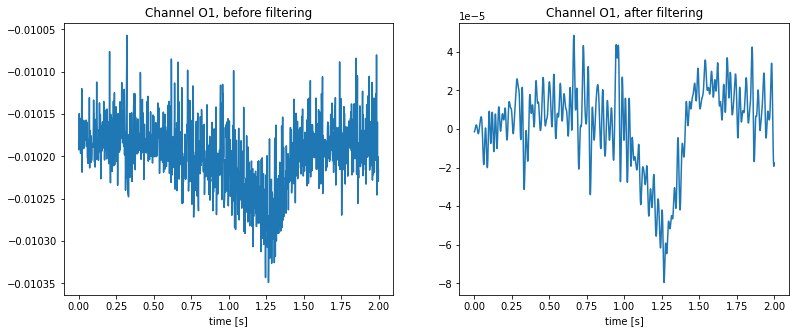

In [8]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(time,before_filtering[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, before filtering')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(time,after_filtering[ch,100*Fs:102*Fs])
plt.title(f'Channel {channels[ch]}, after filtering')
plt.xlabel('time [s]')
plt.show()

## Interpolating

https://mne.tools/dev/overview/implementation.html#channel-interpolation

In [9]:
before_interp = after_filtering

ch_ind, ch_names = get_bad_channels(before_interp, channels)
file.info['bads'] = ch_names
file.interpolate_bads(reset_bads=False, mode='accurate', origin=[0,0,0])

after_interp = file.get_data()

Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors


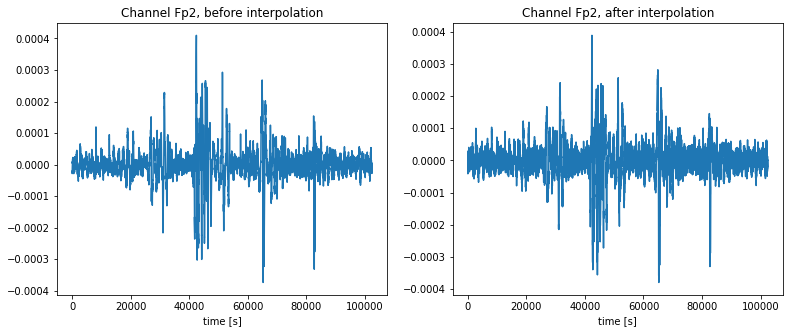

In [10]:
ch_no = ch_ind[1]
start, stop = 150*Fs, 250*Fs

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(before_interp[ch_no,start:stop])
plt.title(f'Channel {channels[ch_no]}, before interpolation')
plt.xlabel('time [s]')

plt.subplot(1,2,2)
plt.plot(after_interp[ch_no,start:stop])
plt.title(f'Channel {channels[ch_no]}, after interpolation')
plt.xlabel('time [s]')
plt.show()

## Epochs preprocessing

In [11]:
ile = len(file.event['latency'])
EVENTS = np.zeros((ile,3))
EVENTS[:,0] = file.event['latency']
EVENTS[:,1] = 0
EVENTS[:,2] = 1

In [12]:
mne.set_log_level(verbose='CRITICAL')
epo = mne.Epochs(file, EVENTS.astype(int), metadata = pd.DataFrame(file.event['tag_type']), 
                 tmin= -0.2, tmax=1, preload=True)
mistakes = np.array([True if i['word_type']!=i['decision'] else False for i in file.event['tag_type']])
epo.drop(mistakes)
epo.drop(get_bad_epochs(epo.get_data()))
epo_befor_resample = epo.get_data()
epo.resample(256)
Fs = int(epo.info['sfreq'])
epo_after_resample = epo.get_data()

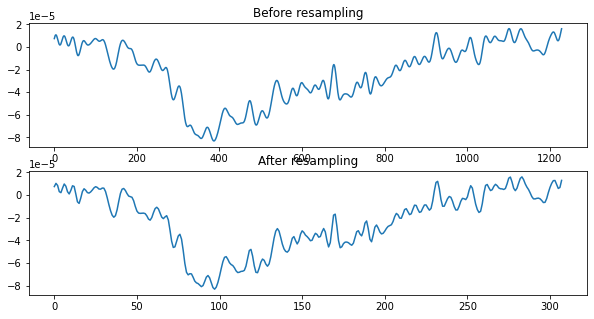

In [13]:
plt.figure(figsize = (10,5))
plt.subplot(2,1,1)
plt.title('Before resampling')
plt.plot(epo_befor_resample[0,0,:])
plt.subplot(2,1,2)

plt.title('After resampling')
plt.plot(epo_after_resample[0,0,:])
plt.show()

## Extracting frequency bands from epochs

In [14]:
no_bands = 5
method = 'iir'
#typowe pasma EEG - delta(0.5-4), theta(4-9), alfa(9-14), beta(14-30), gamma(30-49)
#wyćwiczone na wszystkich - wyzerować któreś i tak sprawdzić
epoki = np.empty((no_bands,epo_after_resample.shape[0],epo_after_resample.shape[1],epo_after_resample.shape[2]))

epoki[0] = epo.copy().filter(0.5,4,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[1] = epo.copy().filter(4,9,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[2] = epo.copy().filter(9,14,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[3] = epo.copy().filter(14,30,method=method,iir_params=dict(order=5, ftype='butter')).get_data()
epoki[4] = epo.copy().filter(30,49,method=method,iir_params=dict(order=5, ftype='butter')).get_data()

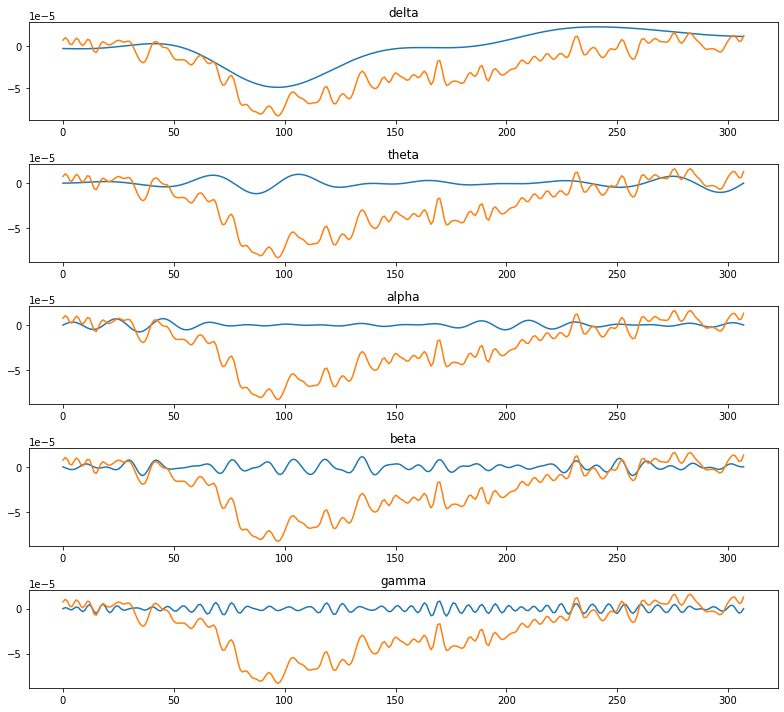

In [15]:
plt.figure(figsize = (11,10))
band_names = ('delta','theta','alpha','beta','gamma')

for i in range(no_bands):
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(epoki[i,0,0,:])
    plt.plot(epo_after_resample[0,0,:])
plt.tight_layout()
plt.show()

## Baseline correction

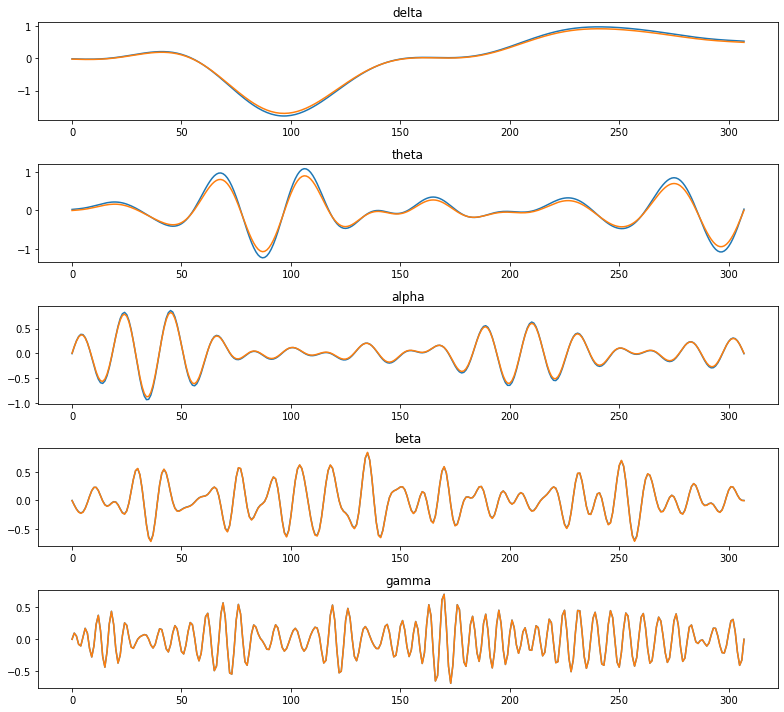

In [16]:
plt.figure(figsize = (11,10))
epo = 0
ch = 0

end_point = int(0.2*Fs)
for i in range(no_bands):
    norm_i = (epoki[i,epo,ch,:] - np.mean(epoki[i,epo,ch,:]) ) / np.std(epoki[i,:,ch,:])
    baseline_i = (epoki[i,epo,ch,:] - np.mean(epoki[i,:,ch,:end_point]) ) / np.std(epoki[i,:,ch,:end_point])
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(norm_i)
    plt.plot(baseline_i)
    
plt.tight_layout()
plt.show()

## Hilber envelope

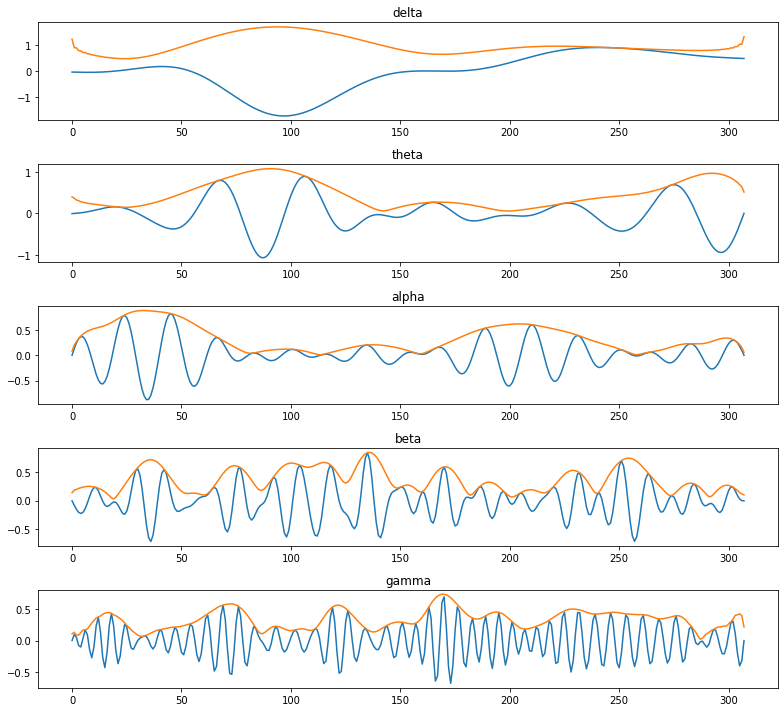

In [17]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs)

for i in range(no_bands):
    baseline_i = (epoki[i,epo,ch,:] - np.mean(epoki[i,:,ch,:end_point]) ) / np.std(epoki[i,:,ch,:end_point])
    hilb_i = np.abs(ss.hilbert(baseline_i))
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(baseline_i)
    plt.plot(hilb_i)
    
plt.tight_layout()
plt.show()

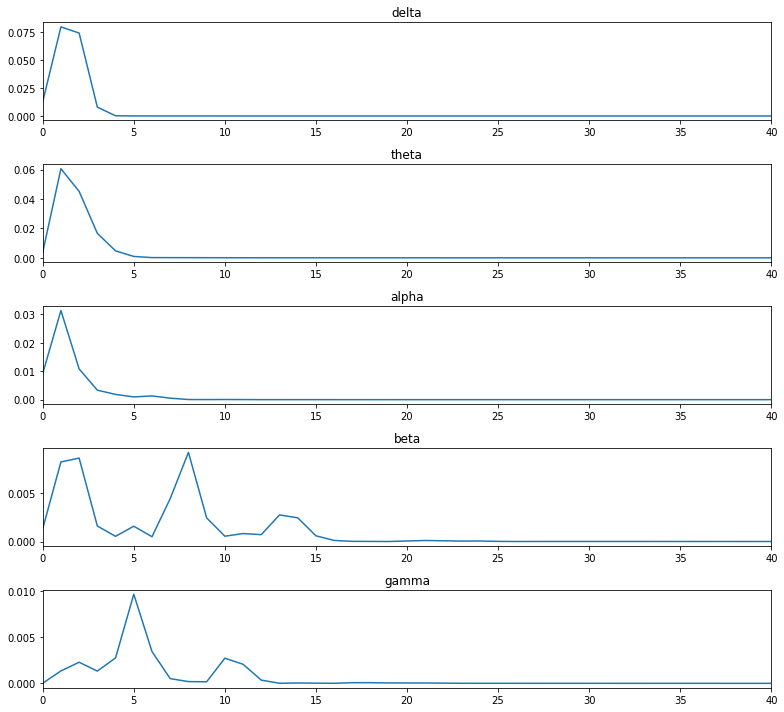

In [18]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs)

for i in range(no_bands):
    baseline_i = (epoki[i,epo,ch,:] - np.mean(epoki[i,:,ch,:end_point]) ) / np.std(epoki[i,:,ch,:end_point])
    hilb_i = np.abs(ss.hilbert(baseline_i))
    f, welch_i = ss.welch(hilb_i, fs=Fs)
    plt.subplot(no_bands,1,i+1)
    plt.title(band_names[i])
    plt.plot(f,welch_i)
    plt.xlim(0,40)
plt.tight_layout()
plt.show()

<Figure size 792x720 with 0 Axes>

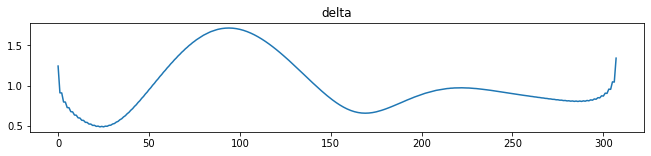

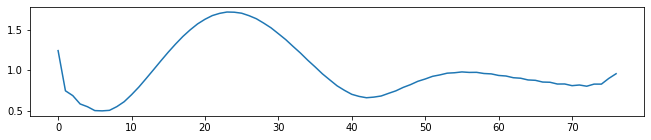

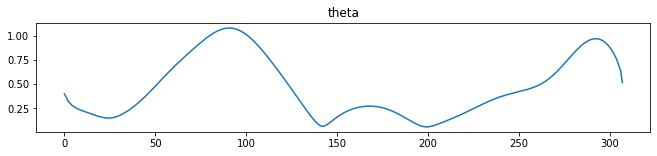

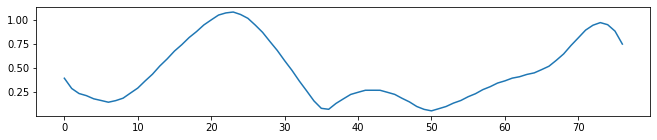

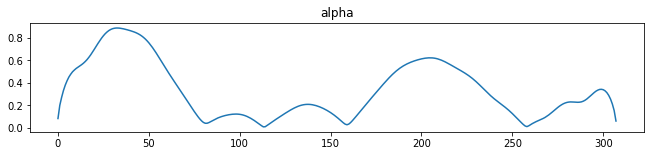

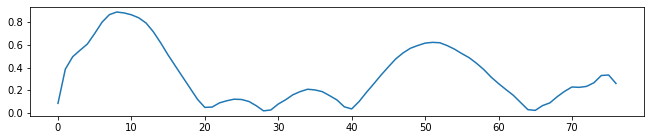

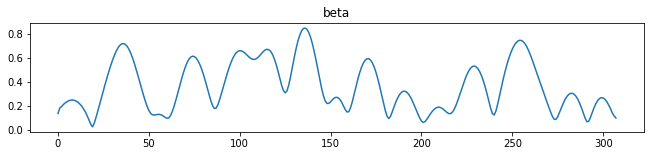

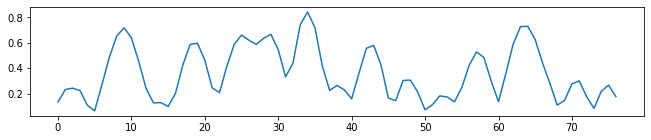

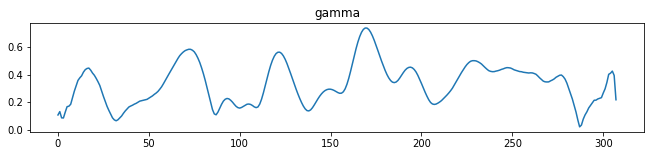

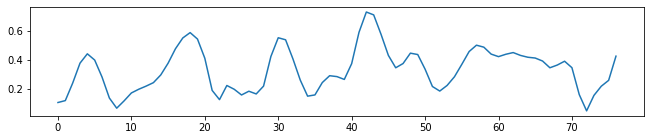

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize = (11,10))
end_point = int(0.2*Fs)

for i in range(no_bands):
    plt.figure(figsize = (11,2))
    baseline_i = (epoki[i,epo,ch,:] - np.mean(epoki[i,:,ch,:end_point]) ) / np.std(epoki[i,:,ch,:end_point])
    hilb_i = np.abs(ss.hilbert(baseline_i))
    hilb_res = mne.filter.resample(hilb_i, up=1.0, down=4)
    plt.title(band_names[i])
    plt.plot(hilb_i)
    plt.show()
    plt.figure(figsize = (11,2))
    plt.plot(hilb_res)
    plt.show()
    
plt.tight_layout()
plt.show()
#widmo - spr do jakiej częstości obciąć (z tego co wychodzi z abs hilberta), 6 razy mniej (?)
#kilka próbek od kilku pacjentów

In [ ]:
#zwykła konwolucyjna sieć - obrazek czas x czestosc, kanały RGB - elektrody
#zbiory uczące - potem będziemy składać sieci
#zbiory - 2 sposoby jak je budować (od Mateusza)